# Noise effects on data (Fig 4)

The effect of various types of noise in the measurement data (Husimi Q).

In [3]:
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from qutip.wigner import qfunc
from qutip import destroy, expect

from qst_nn.utils import plot_three_husimi
from qst_nn.ops import binomial, add_state_noise, GaussianConv, gaus2d
from qst_nn.utils import add_photon_noise

from skimage.util import random_noise

import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Construct a TensorFlow data generator and add noise

In [4]:
def normalize(im):
    """
    Normalize an image by dividing by the max value
    """
    return im/tf.reduce_max(im)

datagen = ImageDataGenerator(
            featurewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            samplewise_center=False,
            rotation_range=180,
            width_shift_range=.2,
            height_shift_range=.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=5,
            zoom_range=0.2,
            preprocessing_function=normalize
)

# Any other preprocessing or removal of the data should be done before this step

# Generate a binomial state

In [7]:
hilbert_size = 32
grid_size = 32

xvec = np.linspace(-5, 5, grid_size)
yvec = np.linspace(-5, 5, grid_size)

rho, mu = binomial(hilbert_size, S=2, N=5, mu=0)

# Simulate noise as a mixed and compute the Q function

In [6]:
rho_mixed = add_state_noise(rho, sigma=0.5, sparsity=0.8)
data_mixed = qfunc(rho_mixed, xvec, yvec, g=2)

# Simulate noise due to Gaussian convolution

In [9]:
nth = 3 # Thermal photon number (determines the Gaussian convolution)

X, Y = np.meshgrid(xvec, yvec) # get 2D variables instead of 1D
gauss_kernel = gaus2d(X, Y, n0=nth)

data_pure = qfunc(rho, xvec, yvec, g=2)
data_gaussian_conv = GaussianConv(gauss_kernel)(data_pure.reshape((1, grid_size, grid_size, 1)))

# convert to Numpy array
data_gaussian_conv = data_gaussian_conv.numpy().reshape(grid_size, grid_size)

# Photon loss noise

In [11]:
tlist = np.linspace(0, 1000, 2000)
photon_loss_states = add_photon_noise(rho, gamma=0.05, tlist=tlist)
rho_photon_loss = photon_loss_states[555]


a = destroy(hilbert_size)
n0 = expect(a.dag()*a, rho)
n = expect(a.dag()*a, rho_photon_loss)

a = destroy(hilbert_size)
print("Photons left", n)
print("(n0 - n)/n0", (n0 - n)/n0)


data_photon_loss = qfunc(rho_photon_loss, xvec, yvec, g=2)

Photons left 4.10136549949845
(n0 - n)/n0 0.500474708489214


# Plot Fig 4

/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:234: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0].pcolor(xvec, yvec, d1,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:238: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1].pcolor(xvec, yvec, d2,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:242: MatplotlibDeprecationWarning: shading='flat' when 

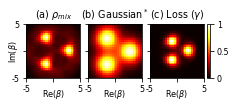

In [12]:
colors1 = colors.LinearSegmentedColormap.from_list("", [(0, "white"),
                                                        (1, "red"),
                                                       ])(np.linspace(0, 1, 256))

mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colors1)

plot_three_husimi(data_mixed, data_gaussian_conv, data_photon_loss, xvec=xvec, yvec=yvec,
                  cmap="hot", #mymap,
                 subtitles=[r"(a) $\rho_{mix}$", r"(b) Gaussian$^*$", r"(c) Loss ($\gamma$)"])

plt.show()

# Affine transform, additive Gaussian and Pepper

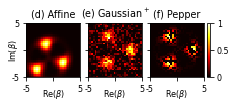

In [13]:
affine = datagen.apply_transform(data_pure.reshape((grid_size, grid_size, 1)), {'theta': 100,
                                                                    'tx': 5, 'ty':5,
                                                                    'shear':5}).reshape(grid_size, grid_size)
data_gaussian = tf.keras.layers.GaussianNoise(0.2)(data_pure/np.max(data_pure), training=True)
# Pepper
data_pepper = random_noise(data_pure, mode="pepper", amount = .5)

plot_three_husimi(affine, data_gaussian, data_pepper, xvec=xvec, yvec=yvec, 
                                    cmap='hot', #mymap
                 subtitles=["(d) Affine", r"(e) Gaussian$^+$", "(f) Pepper"])

plt.show()